In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py as hp
import os
from scipy.stats import cauchy
from time import perf_counter
%matplotlib inline

## 1) Simple training procedures in PyTorch

<br/>

PyTorch is a machine learning library that allows to build computational models on CPUs and GPUs and supports 
automated differentation for model optimization via [error backpropagation](https://en.wikipedia.org/wiki/Backpropagation) and [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

<br/>

### 1.a) Gradient descent

<br/>

We are considering a potentially nonlinear model of the form

$$\hat y = f(x, \theta)$$

which transforms a vector of inputs $x$ into some output vector $y$ via a (nonlinear) function $f$, which depends on a set of parameters $\theta$.
The basic task we would like to solve is to fit this model to some target output $y$.
To this end, we define a loss

$$L = g(\hat y, y)$$

which should measure some form of distance between the model output $\hat y$ and the target output $y$.
To solve our task, we want to find a set of parameters $\theta$ that minimizes that loss $L$.
This can be achieved by gradient descent algorithms.

**Gradient descent algorithm steps:**

1. Calculate the loss $L$ for the current set of parameters $\theta$
2. Calculate the gradient, i.e. the derivate of the loss with respect to each parameter $\theta_i$
3. Take a step along the direction in parameter space that reduces $L$ the most
4. Repeat.

<br/>

### 1.b) Error backpropagation

<br/>

Step 2 of the gradient descent algorithm requires to calculate $\frac{\partial L}{\partial \theta_i}$ for each parameter $\theta_i$.
If we had a simple linear model of the form 

$$f(x) = w x + b,$$

and a quadratic loss term

$$L = \sum_i (y_i - f(x_i))^2$$

we can use the chain rule to calculate

$$\frac{\partial L(x,y)}{\partial w} = 2 \sum_i (y_i - f(x_i)) \frac{\partial f(x_i)}{\partial w} = 2 \sum_i (y_i - f(x_i)) x_i,$$

and 

$$\frac{\partial L(x,y)}{\partial b} = 2 \sum_i (y_i - f(x_i)) \frac{\partial f(x_i)}{\partial b} = 2 \sum_i (y_i - f(x_i)).$$

If we had a model with multiple nested functions, such as 

$$f(x) = f_1(f_2(x, \theta_2), \theta_1),$$

calculation of the gradient is still solved by the chain rule, it just involves a few more steps:

$$\frac{\partial L(x,y)}{\partial \theta_2}  = 2 \sum_i (y_i - f(x_i)) \frac{\partial f_1}{\partial f_2} \frac{\partial f_2}{\partial \theta_2},$$

and 

$$\frac{\partial L(x,y)}{\partial \theta_1}  = 2 \sum_i (y_i - f(x_i)) \frac{\partial f_1}{\partial \theta_1}.$$

<br/>

In PyTorch, the gradients are calculated for you automatically via the functionalities of `torch.autograd`. 
It organizes all transformations that an input $x$ goes through in a directed, acyclic graph and uses this graph to calculate derivates based on the chain rule:

<img src="img/autograd.jpg" width=800 />

<br/>

### 1.c) Use example

<br/>

Let's explore how we can use these functionalities to fit a simple linear regression model of the form $\hat y = f(x) = w x + b$.
In the cell below, training data is created from such a linear model.

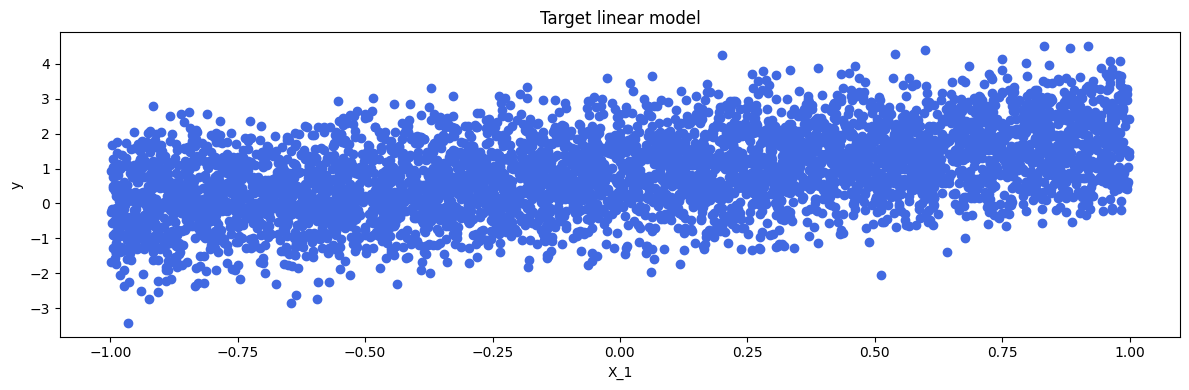

In [2]:
# generate target parameters
n_samples = 5000
n_features = 10
w = np.random.uniform(-1.0, 1.0, size=(n_features,))
b = np.random.randn()

# generate target data
X = np.random.uniform(-1.0, 1.0, size=(n_samples, n_features))
y = X @ w + b

# plot data set
fig, ax = plt.subplots(figsize=(12, 4))
idx = np.argmax(np.abs(w))
ax.scatter(X[:, idx], y, color="royalblue")
ax.set_title("Target linear model")
ax.set_xlabel(f"X_{idx}")
ax.set_ylabel("y")
plt.tight_layout()

**Variable initialization**

Let's implement a model in PyTorch that starts from a random set of weights $w$ and bias terms $b$ and finds the ones that generated the training data. 
We will start by implementing PyTorch variables and defining which variables to optimize. 

In [28]:
# check which device to use
device = "cpu" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)

# create pytorch tensors
X_t = torch.tensor(X, device=device)
y_t = torch.tensor(y, device=device)
w_t = torch.tensor(np.random.uniform(-1.0, 1.0, (n_features,)), device=device, requires_grad=True)
b_t = torch.randn(1, device=device, requires_grad=True)

# check value of gradient at tensors
print(w_t.grad)
print(w_t.requires_grad)

None
True


/tmp/ipykernel_3902/1162707317.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_t = torch.tensor(X, device=device)
/tmp/ipykernel_3902/1162707317.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y, device=device)


**Loss function**

Next, we define a quadratic loss function.

In [4]:
# define a loss function
def squared_loss(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return torch.sum((output - target)**2)

**Automated backpropagation / gradient calculation**

Let's calculate the quadratic loss on the first training sample given the current parameter values and call the automated gradient calculation routine of PyTorch.
|

In [5]:
# calculate error for one sample
y_hat = X_t[0, :] @ w_t + b_t
loss = squared_loss(y_hat, y_t[0])

# backpropagate the error through the autograd graph
loss.backward()

# check gradient at different tensors
print(w_t.grad)

tensor([ 0.7217,  0.8286, -1.8974, -1.4857,  1.9761,  1.1867,  0.1822,  1.1629,
         0.5575, -0.8280], device='cuda:0')


**Model training**

Those are all the ingredients we need. Let's train a model.

In [6]:
# get initial model prediction and parameters
y_0 = X_t @ w_t + b_t
y_0 = y_0.cpu().detach().numpy()
w_0 = w_t.cpu().detach().numpy()

In [7]:
# set some variables for parameter training
n_epochs = 1000
print_epochs = 100
lr = 2e-6
reg_strength = 1e-4
loss_hist = []

# perform training
for epoch in range(n_epochs):

    # get model prediction
    y_pred = X_t @ w_t + b_t
    
    # calculate loss over all samples
    loss = squared_loss(y_pred, y_t) + reg_strength*(torch.sum(w_t**2) + b_t**2)
    
    # reset the gradients of all trainable parameters
    w_t.grad = None
    b_t.grad = None
    
    # calculate gradient via backpropagation
    loss.backward()
    
    with torch.no_grad():
        
        # make step along steepest gradient direction
        w_t -= lr * w_t.grad
        b_t -= lr * b_t.grad
    
    # store results and report progress
    loss_hist.append(loss.item())
    if epoch % print_epochs == 0:
        print(f"Loss after training epoch #{epoch}: {loss_hist[-1]}.")

Loss after training epoch #0: 15268.331054252085.
Loss after training epoch #100: 2281.9990058367366.
Loss after training epoch #200: 598.9347489721914.
Loss after training epoch #300: 165.79340770825266.
Loss after training epoch #400: 46.10411666057205.
Loss after training epoch #500: 12.837522820502505.
Loss after training epoch #600: 3.578392511365215.
Loss after training epoch #700: 0.9986131107969609.
Loss after training epoch #800: 0.2791608677901903.
Loss after training epoch #900: 0.07834632766309461.


In [8]:
# get model prediction and parameters after fitting
y_1 = X_t @ w_t + b_t
y_1 = y_1.cpu().detach().numpy()
w_1 = w_t.cpu().detach().numpy()

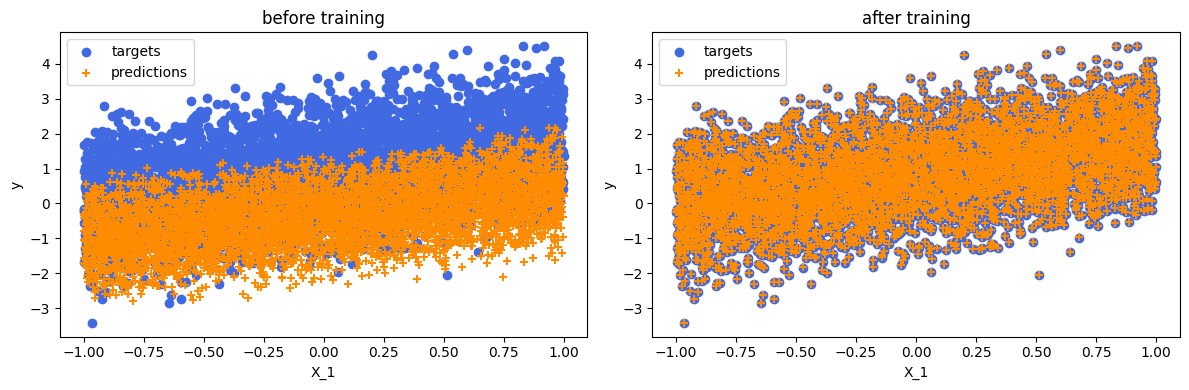

In [9]:
# plot the model behavior before and after training
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for ax, title, prediction in zip(axes, ["before training", "after training"], [y_0, y_1]):
    ax.scatter(X[:, idx], y, color="royalblue", label="targets")
    ax.scatter(X[:, idx], prediction, color="darkorange", marker="+", label="predictions")
    ax.set_title(title)
    ax.set_xlabel(f"X_{idx}")
    ax.set_ylabel("y")
    ax.legend()
plt.tight_layout()

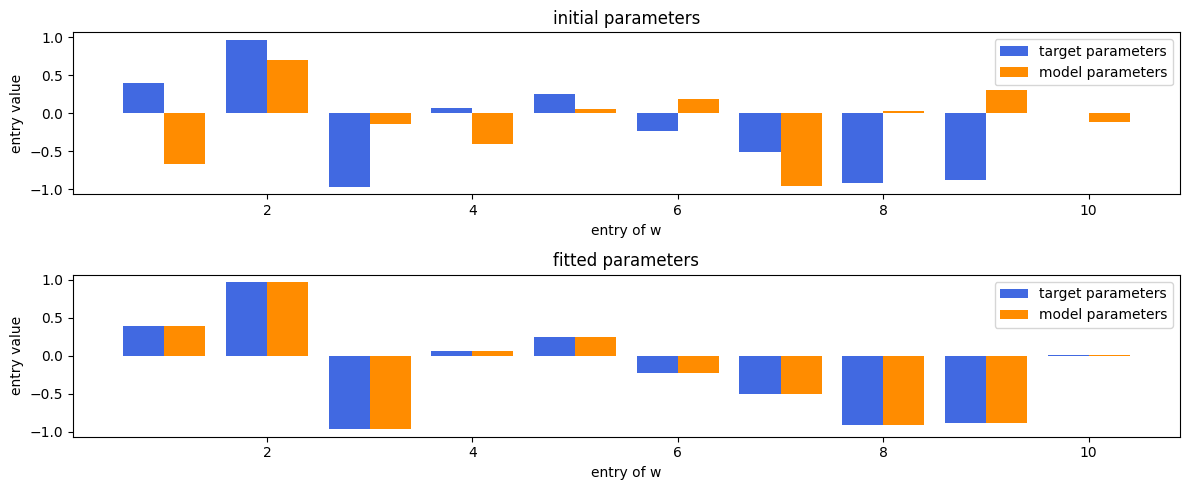

In [10]:
# compare the initial and fitted parameters to the true parameters
fig, axes = plt.subplots(nrows=2, figsize=(12, 5))
x = np.arange(1, n_features+1)
for ax, title, w_hat in zip(axes, ["initial parameters", "fitted parameters"], [w_0, w_1]):
    ax.bar(x-0.2, w, width=0.4, color="royalblue", label="target parameters")
    ax.bar(x+0.2, w_hat, width=0.4, color="darkorange", label="model parameters")
    ax.set_xlabel("entry of w")
    ax.set_ylabel("entry value")
    ax.set_title(title)
    ax.legend()
plt.tight_layout()

## 2) Training dynamical systems models in PyTorch

<br/>

### 2.a) Gradient calculation in dynamical systems

<br/>

Let's turn to dynamical systems models, i.e. models that depend on time:

$$\hat y(t) = f(x(t), \theta, t).$$

A simple version of such a model could be an $N$-dimensional linear differential equation system of the form

$$\frac{d h(t)}{dt} = - w h(t) + A x(t),$$

which is driven by an input $x$ with $m$ features and is governed by the decay rates $w^{N}$ and the input weights $A^{N \times m}$.
A $k$-dimensional model output $\hat y(t)$ could be modeled a simple linear readout of the dynamical systems state $\hat y(t) = B h(t)$ with readout weights $B^{k \times N}$.
If we stick with the quadratic loss that we defined above, performing gradient descent to optimize the decay rates, for example, requires us to calculate $\frac{\partial L}{\partial w_i}$ for every entry in $w$:

$$\frac{\partial L}{\partial w_i} = 2 \sum_k (y_k(t) - \hat y_k(t)) \frac{\partial \hat y_k(t)}{\partial w_i} = 2\sum_k(y_k(t) - \hat y_k(t)) B_{ki} \frac{\partial h_i(t)}{\partial w_i}.$$

However, since we do not know what $h(t)$ is for a given $t$, we cannot calculate $\frac{\partial h_i(t)}{\partial w_i}$ yet.
Finding $h(t)$ requires solving an integral which often cannot be solved analytically.
Luckily, in the case of the linear model we chose above, a solution exists:

$$h(t) = \int_0^t \frac{d h(t')}{dt} dt' = e^{-w t} h(t) + \int_0^t e^{-w (t - \tau)} A x(\tau) d\tau.$$

To get rid of the second integral, we assume that the input $x(t)$ is piecewise linear, i.e. that we can represent it as a time-discretized vector $x_n$, where the time advance from any $n$ to $n+1$ is a small time interval of size $\Delta$.
Within any such time interval, we approximate all $x(t)$ that fall into that interval to take on the same value $x_n$.
This approximation yields

$$h_{n+1} = e^{-w \Delta} h_n + A x_n.$$

Now we arrived at a model description for which we can use **backpropagation through time** to solve our gradient calculation problem.

<br/>

### 2.b) Backpropagation through time

<br/>

Backpropagation through time works by (i) organizing the relationship between the different $h_{n}$ for all $n$ in a directed, acyclic graph again,
and (ii) applying the same chain rule principle to calculate the gradient that we used for such graphs in the previous example.

<img src="img/bptt.png" width=800 />

### 2.c) BPTT in action

<br/>

Let's try training a model of the form 

$$\frac{d h(t)}{dt} = - w h(t) + A x(t),$$

$$\hat y(t) = B h(t),$$

to low-pass filter a noisy input signal with two different filters.
First, let's set up the model and find an initial $W$ and $A$ for which the model behaves well.

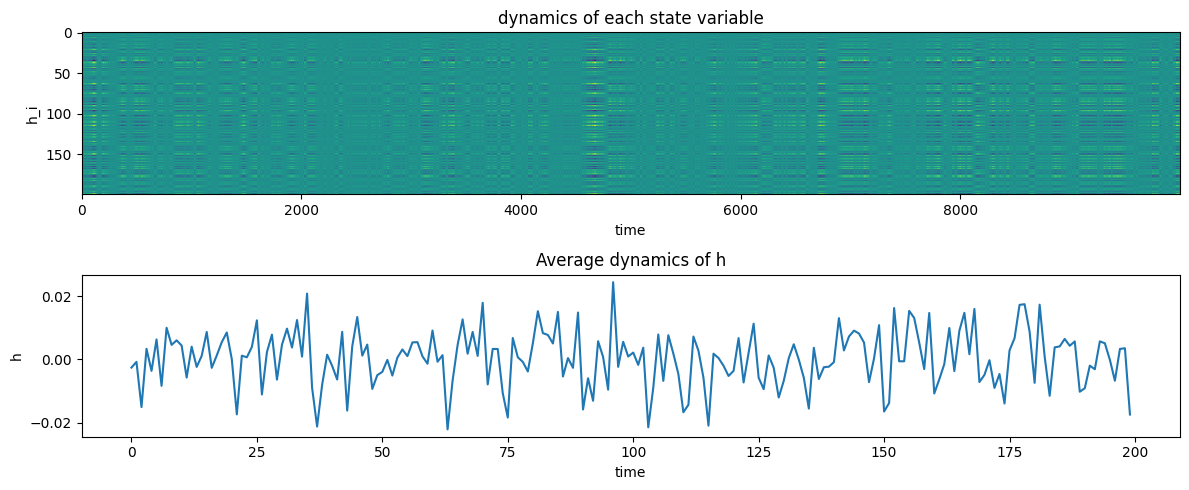

In [11]:
# model parameters
N = 200
m = 1
k = 1
w = np.random.uniform(10.0, 20.0, size=(N,))
w = torch.tensor(w, device=device, requires_grad=True)
A = torch.tensor(np.random.randn(N, m) * 0.02, device=device, requires_grad=True)
B = torch.tensor(np.random.randn(k, N), device=device, requires_grad=True)
h = torch.zeros(N, device=device)

# simulation parameters
Delta = 1e-3
steps = 10000

# pre-calculate the costly exponential function
h_decay = torch.exp(-w * Delta)

# simulation of model dynamics for random input
h_hist = []
with torch.no_grad():
    for step in range(steps):
        x = torch.randn(m, device=device)
        h_new = h_decay * h + A @ x
        h_hist.append(h_new.cpu().detach().numpy())
        h = h_new
states = np.asarray(h_hist)

# plotting of results
fig, axes = plt.subplots(nrows=2, figsize=(12, 5))
ax = axes[0]
ax.imshow(states.T, aspect="auto", interpolation="none")
ax.set_xlabel("time")
ax.set_ylabel("h_i")
ax.set_title("dynamics of each state variable")
ax = axes[1]
ax.plot(np.mean(states, axis=0))
ax.set_xlabel("time")
ax.set_ylabel("h")
ax.set_title("Average dynamics of h")
plt.tight_layout()

Now that we have found a set of parameters for which the model doesn't just explode, let's see whether it can serve to denoise a periodic, noisy input signal.

In [12]:
# training settings
n_epochs = 500
print_epochs = 50
lr = 2e-3

# pytorch loss function and optimizer
loss_func = torch.nn.MSELoss()
optim = torch.optim.Adamax([w, A, B], lr=lr, betas=(0.9, 0.999))

# generate target data
omegas = [0.5]
noise_lvl = 0.3
time = np.arange(0, steps)*Delta
y = np.zeros((steps, k))
for i, omega in enumerate(omegas):
    y[:, i] = np.sin(2.0*np.pi*omega*time)
y_t = torch.tensor(y, device=device)

# training procedure
losses = []
for epoch in range(n_epochs):
    
    # generate input by adding noise to target data
    X = y*(1.0-noise_lvl) + y*noise_lvl*np.random.randn(steps, m)
    X_t = torch.tensor(X, device=device)
    
    # calculate decay term for current decay rates
    h_decay = torch.exp(-w * Delta)
    
    # calculate model response over time
    h = torch.zeros(N, device=device)
    y_hist = []
    for step in range(steps):
        h_new = h_decay * h + A @ X_t[step, :]
        y_tmp = B @ h_new
        h = h_new
        y_hist.append(y_tmp)
    
    # calculate loss
    y_hat = torch.stack(y_hist)
    loss = loss_func(y_t, y_hat)
    
    # optimization step
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # save results
    losses.append(loss.item())
    if epoch % print_epochs == 0:
        print(f"Mean-squared error after epoch #{epoch}: {losses[-1]}")
        
# get model output from last epoch
y_hat = y_hat.cpu().detach().numpy()

Mean-squared error after epoch #0: 9.60250077351787
Mean-squared error after epoch #50: 0.19563540743317076
Mean-squared error after epoch #100: 0.07207062396375054
Mean-squared error after epoch #150: 0.057619120283038526
Mean-squared error after epoch #200: 0.0444115891155754
Mean-squared error after epoch #250: 0.03338233916900264
Mean-squared error after epoch #300: 0.026342322365098897
Mean-squared error after epoch #350: 0.01942137688126715
Mean-squared error after epoch #400: 0.015244434422648608
Mean-squared error after epoch #450: 0.012065436287914396


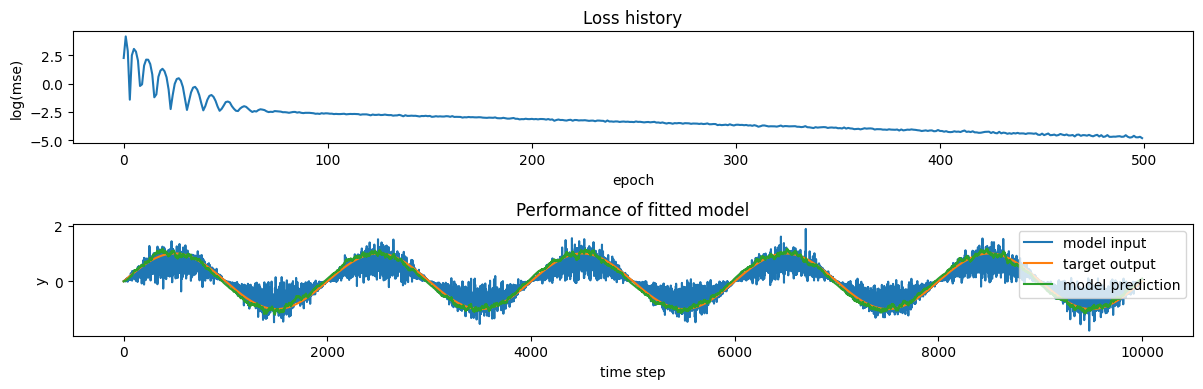

In [14]:
# plot results
fig, axes = plt.subplots(nrows=2, figsize=(12, 4))
ax = axes[0]
ax.plot(np.log(losses))
ax.set_xlabel("epoch")
ax.set_ylabel("log(mse)")
ax.set_title("Loss history")
ax = axes[1]
ax.plot(X[:, 0], label="model input")
ax.plot(y[:, 0], label="target output")
ax.plot(y_hat[:, 0], label="model prediction")
ax.set_title("Performance of fitted model")
ax.set_xlabel("time step")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()

## 3) Training spiking neural networks in PyTorch

<br/>

### 3.a) Gradient calculation in spiking neural networks

<br/>

The problem of calculating the gradients for parameters in dynamical systems becomes hard when the dynamical system is a spiking neural network.
Let's consider a recurrent neural network of coupled quadratic integrate-and-fire (QIF) neurons, where the dynamics of each neuron are governed by a membrane potential $v_i$ and a synaptic activation $s_i$: 

$$\frac{d v_i(t)}{dt} = \frac{v_i^2(t)}{\tau} + W s(t) + A x(t),$$

$$\frac{d s_i(t)}{dt} = -\frac{s_i(t)}{\tau_s} + \sum_{t^k} \delta(t-t_i^k).$$

The parameters of the model are the membrane time constant $\tau$, the synaptic time constant $\tau_s$, the synaptic coupling strengths $W_{ij}$, and the input weights $A_{ij}$.
The time points $t_i^k$ indicate the times when $v_i > v_{peak}$, i.e. when the membrane potential of the $i$-th neuron reaches the threshold $v_{peak}$.
The Dirac delta functions $\delta$ are infinitely narrow spike pulses centered around these threshold-crossing times. 
The sum over all of them represents the spike train of a given neuron. 
At each spike event, the membrane potential of the spiking neuron is reset: $v_i \leftarrow v_{reset}$.

We are again concerned with gradient calculation and backpropagation in this model.
The first issue arises when we try to evaluate a partial derivative like $\frac{\partial v_i}{\partial A}$.
Despite the relative simplicity of the QIF neuron model, we cannot solve the integral 

$$v_i(t) = \int_0^t [\frac{v_i^2(t')}{\tau} + W s(t') + A x(t')] dt',$$

even if we use the piecewise linear approximation for both $s(t)$ and $x(t)$.
To nonetheless be able to use parameter optimization via gradient descent in nonlinear neuron models, we use the [Euler method](https://en.wikipedia.org/wiki/Euler_method) to approximate $v(t)$ and $s(t)$:

$$v_{n+1} = v_n + \Delta \frac{d v_n}{dt},$$
$$s_{n+1} = s_n + \Delta \frac{d s_n}{dt}.$$

Given that approximation, let's choose the output to be a linear readout $\hat y_n = B s_n$ and the loss the be a quadratic loss $L = \sum_n (y_n - \hat y_n)^2$ again.

Then, the second problem we have to deal for gradient calculation is the discontinuity of the spiking mechanism.
If we wanted to optimize the recurrent weights $W$, it requires the calculation of

$$\frac{\partial L}{\partial W_{ij}} = 2 \sum_k (y_k - \hat y_k) B_{ki} \frac{\partial s_i}{\partial W_{ij}}.$$

However, the partial derivative $\frac{\partial s_i}{\partial W_{ij}}$ is not defined at the spiking discontinuity.
One solution to this issue is to provide a **surrogate gradient** to pytorch.

<br/>

### 3.b) Surrogate gradients for spiking neurons.

<br/>

A particular surrogate gradient called *SuperSpike* has been established by [Zenke and Ganguli in 2018](https://direct.mit.edu/neco/article-abstract/30/6/1514/8378/SuperSpike-Supervised-Learning-in-Multilayer).
The main idea is that the spike threshold $v > v_{peak}$ can be formalized via two heaviside step functions and that this step function can be approximated by a "fast" sigmoid:

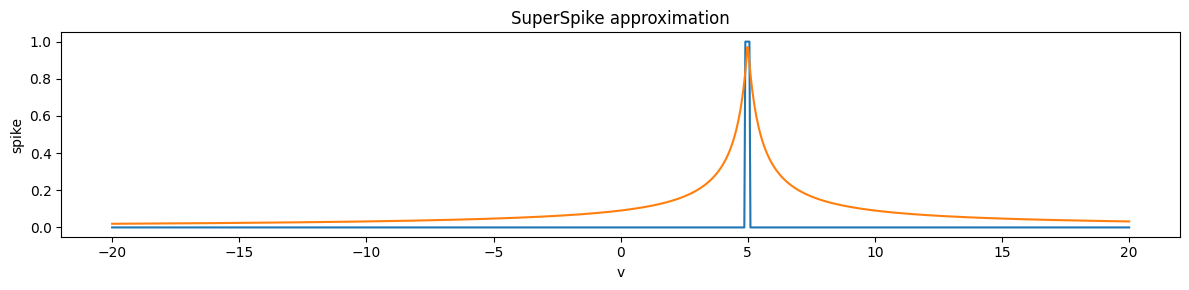

In [29]:
# parameters
v_peak = 5.0
slope = 2.0
width = 0.1
vs = np.linspace(-20.0, 20.0, 1000)
x = vs - v_peak

# calculate heaviside target output
heavi_spike = np.heaviside(x + width, 1.0) * np.heaviside(-x+width, 1.0)

# calculate sigmoid approximation
sigmoid_spike = 1.0/(1.0 + slope*np.abs(x))

# plot heaviside vs. sigmoid
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(vs, heavi_spike, label="heaviside")
ax.plot(vs, sigmoid_spike, label="sigmoid")
ax.set_xlabel("v")
ax.set_ylabel("spike")
ax.set_title("SuperSpike approximation")
plt.tight_layout()

While we still want to use proper spiking neurons and not rate neurons for the network dynamics, we can use the sigmoid approximation to allow backpropagation through spiking events.
The following spike class implements this functionality in PyTorch:

In [30]:
class Spike(torch.autograd.Function):

    slope = 40.0
    center = torch.tensor(0.0)

    @staticmethod
    def forward(ctx, x: torch.Tensor) -> torch.Tensor:
        ctx.save_for_backward(x)
        return torch.heaviside(x, Spike.center)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> torch.Tensor:
        x, = ctx.saved_tensors
        return grad_output/(1.0 + Spike.slope*torch.abs(x))**2
    
spike_func = Spike.apply

We can use this spike function to implement spike resetting in a PyTorch implementation of the QIF spiking network we defined above. Due to the custom `backward` method, automated gradient calculation will work despite the discontinuous spike events.

In [31]:
def qif_step(x: torch.Tensor, v: torch.Tensor, s: torch.Tensor, W: torch.Tensor,
             tau: float, tau_s: float, v_peak: float, dt: float) -> tuple:
    
    # calculate spikes in the network
    spikes = spike_func(v - v_peak)
    reset = spikes.detach()
    
    # calculate right-hand side of the differential equations
    dv = v**2/tau + W @ s + x
    ds = -s/tau_s + spikes
    
    # perform Euler integration step (and spike reset)
    v_new = (v + dt*dv) * (1.0-2.0*reset)
    s_new = s + dt*ds
    
    return v_new, s_new  

### 3.b) Fitting a QIF network to recognize spoken digits

<br/>

Let's try to fit a network of QIF neurons based on these approximations.
We will make use of the Heidelberg spoken digits data set, which translated the audio files of spoken digits 1-9 in English and German (20 target classes overall) into spiking patterns via a biomechanical model of spike generation in the cochlea. You can download the data set [here](https://zenkelab.org/datasets/).

The cell below loads the data:

In [32]:
# directory where data is saved
path = "/home/rgf3807/OneDrive/data/SHD"

# load h5 file
data = hp.File(os.path.join(path, "shd_train.h5"))

# get spike representations of spoken digits and corresponding labels
X_data = data["spikes"]
y_data = data["labels"]

Let's check out a few input of the training samples.
The function below transforms the training data into torch tensors.

In [33]:
def data_generator(X, y, n_samples: int, n_steps: int = 100, n_inp: int = 700, 
                   max_time: float = 1.4, shuffle: bool = True):

    labels = np.array(y, dtype=np.int16)
    sample_index = np.arange(len(labels))

    firing_times = X['times']
    units_fired = X['units']
    
    time_bins = np.linspace(0, max_time, num=n_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter<n_samples:
        
        idx = sample_index[counter]
        spike_times = torch.LongTensor(np.digitize(firing_times[idx], time_bins))
        inp_neurons = torch.LongTensor(np.asarray(units_fired[idx], dtype=np.int16))
        X_batch = torch.zeros([n_steps, n_inp])
        X_batch[spike_times, inp_neurons] = 1.0
        y_batch = torch.tensor([labels[idx]], dtype=torch.long)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [34]:
digit_names = [
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine",
    "null", "eins", "zwei", "drei", "vier", "fuenf", "sechs", "sieben", "acht", "neun"
]

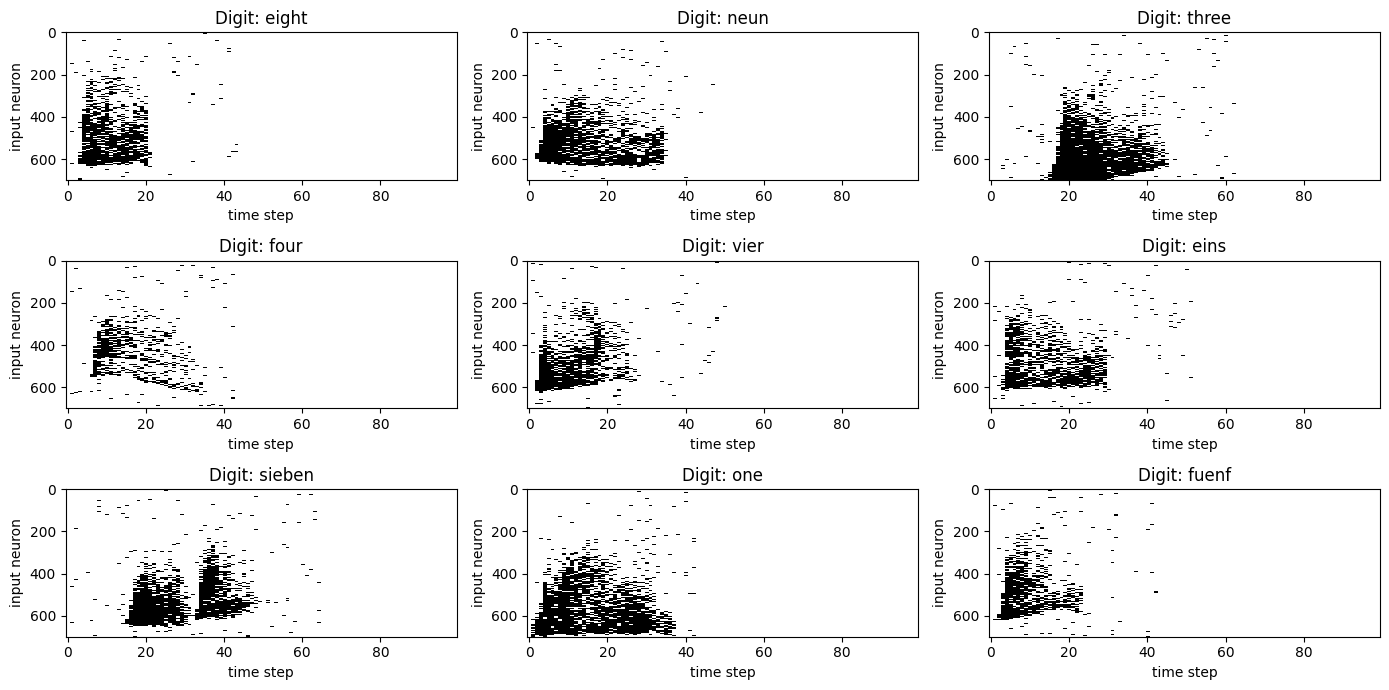

In [35]:
n_samples = 9
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7))
single_axes = [axes[0, 0], axes[0, 1], axes[0, 2], 
               axes[1, 0], axes[1, 1], axes[1, 2],
               axes[2, 0], axes[2, 1], axes[2, 2]]
for (X, y), ax in zip(data_generator(X_data, y_data, n_samples), single_axes):
    ax.imshow(X.cpu().detach().numpy().T, aspect="auto", interpolation="none", cmap="Greys")
    idx = y.cpu().detach().numpy()[0]
    ax.set_title(f"Digit: {digit_names[idx]}")
    ax.set_xlabel("time step")
    ax.set_ylabel("input neuron")
plt.tight_layout()

To train the LIF model to associate the input spiking patterns with the digit classes,
we will go through the following steps in the next code cells:

1. Define the model parameters
2. Check the model dynamics and find a good set of initial conditions
3. Fit the model on the spoken digit data set

In [57]:
# model parameters
N = 400
taus = np.random.uniform(5e-3, 15e-3, (N,))
taus = torch.tensor(taus, device=device)
tau_s = 20e-3
w_scale = 0.2
v_peak = 1.0

# network connectivity
W = np.random.randn(N, N) * w_scale
W = torch.tensor(W, device=device, requires_grad=True)

# readout layer (dont change the size)
n_readout = 20
B = np.random.randn(n_readout, N) * w_scale
B = torch.tensor(B, device=device, requires_grad=True)

# input layer (dont change the size)
n_inp = 700
A = np.random.randn(N, n_inp) * w_scale
A = torch.tensor(A, device=device, requires_grad=True)

The function below serves to simulate the model dynamics for a given input: 

In [58]:
def qif(X: torch.Tensor, W: torch.Tensor, A: torch.Tensor, B: torch.Tensor, 
        tau: float, tau_s: float, step_size: float, dt: float, v_peak: float, 
        **kwargs) -> tuple:
     
    N = W.shape[0]
    n_steps = X.shape[0]
    integration_steps = int(step_size/dt)
    
    # initialize network state
    v = kwargs["v"] if "v" in kwargs else torch.zeros((N,), device=device)
    s = kwargs["s"] if "s" in kwargs else torch.zeros((N,), device=device)
    
    readout, s_rec, v_rec = [], [], []
    for step in range(n_steps):
        
        # calculate network response to input
        inp = A @ X[step, :]
        for _ in range(integration_steps):
            v_new, s_new = qif_step(inp, v, s, W, tau, tau_s, v_peak, dt)
            v = v_new
            s = s_new
        out = B @ s
        
        # save network response
        readout.append(out)
        v_rec.append(v)
        s_rec.append(s)
    
    return torch.stack(readout), torch.stack(v_rec), torch.stack(s_rec)

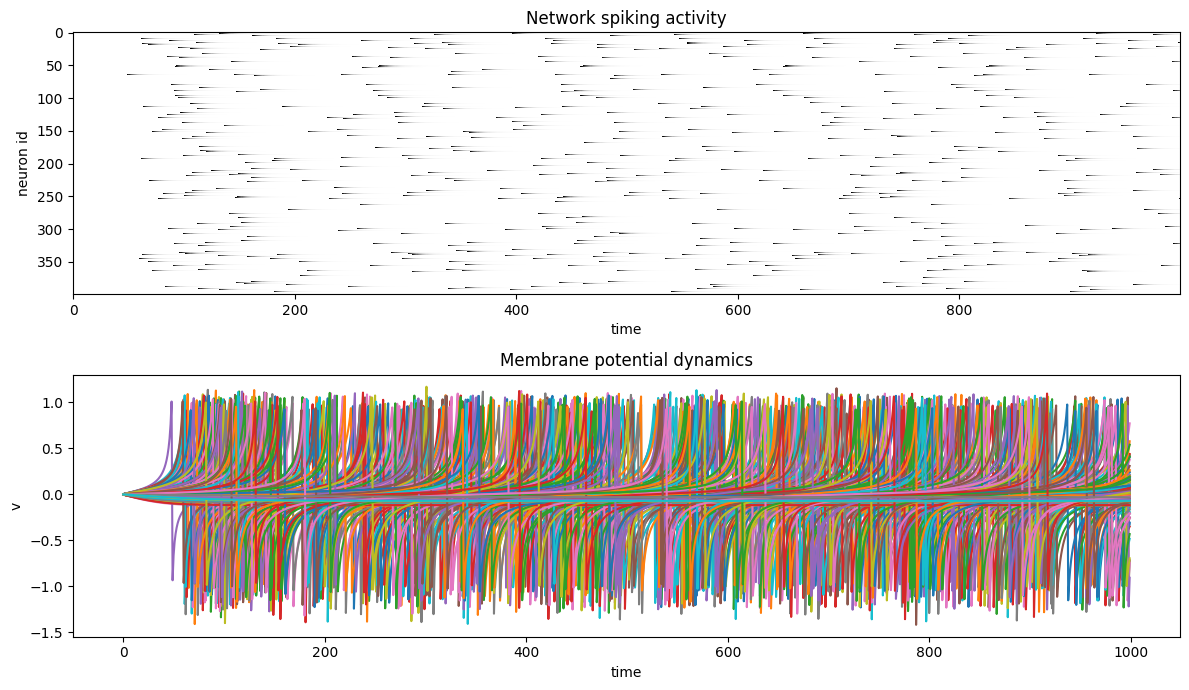

In [59]:
# simulation parameters
T = 1.0
Delta = 1e-3
steps = int(T/Delta)
inp = torch.zeros((steps, n_inp,), device=device) + 0.1

# simulation
with torch.no_grad():
    readout, v_rec, s_rec = qif(inp, W, A, B, taus, tau_s, 2.0*Delta, Delta, v_peak)
s = s_rec.cpu().numpy()
v = v_rec.cpu().numpy()

# plotting
fig, axes = plt.subplots(nrows=2, figsize=(12, 7))
ax = axes[0]
ax.imshow(s.T, aspect="auto", interpolation="none", cmap="Greys")
ax.set_title("Network spiking activity")
ax.set_xlabel("time")
ax.set_ylabel("neuron id")
ax = axes[1]
ax.plot(v)
ax.set_title("Membrane potential dynamics")
ax.set_xlabel("time")
ax.set_ylabel("v")
plt.tight_layout()

In [ ]:
# training parameters to play with
lr = 1e-3
n_epochs = 50
n_samples = 500
v_peak = 1.0
epsilon_rate = 1e-6
epsilon_spikes = 1e-6

# initial condition of the network 
# (currently this chooses the initial state of the system at 
# each trial as the final state of the system after the simulation performed above)
kwargs = {"v": v_rec[-1, :], "s": s_rec[-1, :]}

# training parameters that should be left untouched
max_time = 1.4
n_steps = 100
input_step_size = max_time/n_steps
min_spike_rate = 1.0/n_steps

# torch loss and optimizer (feel free to play around with the optimizer as well)
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adamax([W, A, B], lr, betas=(0.9, 0.999))

# optimization procedure
losses = []
for epoch in range(n_epochs):
    
    t0 = perf_counter()
    epoch_loss, predictions, targets = [], [], []
    for X, y in data_generator(X_data, y_data, n_samples):
        
        # forward simulation of SNN activity for a single training sample
        readout, _, spikes = qif(X, W, A, B, taus, tau_s, input_step_size, 
                                 Delta, v_peak, **kwargs)
        
        # calculate loss on the training sample
        readout_max, _ = torch.max(readout, 0)
        prediction = torch.reshape(readout_max, (1, readout_max.shape[0]))
        reg_rate = epsilon_rate*torch.max(torch.mean(spikes, dim=1))
        reg_spikes = epsilon_spikes*torch.mean(torch.nn.functional.relu(min_spike_rate - torch.sum(spikes, dim=0)))
        loss = loss_func(prediction, y) + reg_rate + reg_spikes
        
        # save results
        epoch_loss.append(loss)
        predictions.append(np.argmax(readout_max.cpu().detach().numpy()))
        targets.append(y.cpu().detach().numpy()[0])
    
    # optimization step
    loss = torch.sum(torch.stack(epoch_loss))
    optim.zero_grad()
    loss.backward()
    optim.step()
            
    # print progress
    losses.append(loss.item())
    t1 = perf_counter()
    print(f"Finished training epoch #{epoch+1} after {int(t1-t0)}s. Current loss: {losses[-1]}")
    
print(f"Training finished! Final loss: {losses[-1]} (initial loss: {losses[0]}).")

Finished training epoch #1 after 308.18447652599934s. Current loss: 1497.891796297121
Finished training epoch #2 after 217.45157663600003s. Current loss: 1497.865294152228
Finished training epoch #3 after 184.7956453200004s. Current loss: 1497.8652205144313
Finished training epoch #4 after 178.59734739600026s. Current loss: 1497.8601360171454
Finished training epoch #5 after 189.1666796970003s. Current loss: 1497.8638670309945
Finished training epoch #6 after 190.60900385200148s. Current loss: 1497.8632335531604


In [50]:
# calculate correct classifications for each spoken digit
target_classes = np.arange(20, dtype=np.int16)
targets = np.asarray(targets)
correct_classifications = []
for t in target_classes:
    target_idx = np.argwhere(targets == t).squeeze()
    if len(target_idx) > 0:
        correct = np.mean([predictions[idx] == t for idx in target_idx])
    else:
        correct = -0.1
    correct_classifications.append(correct)

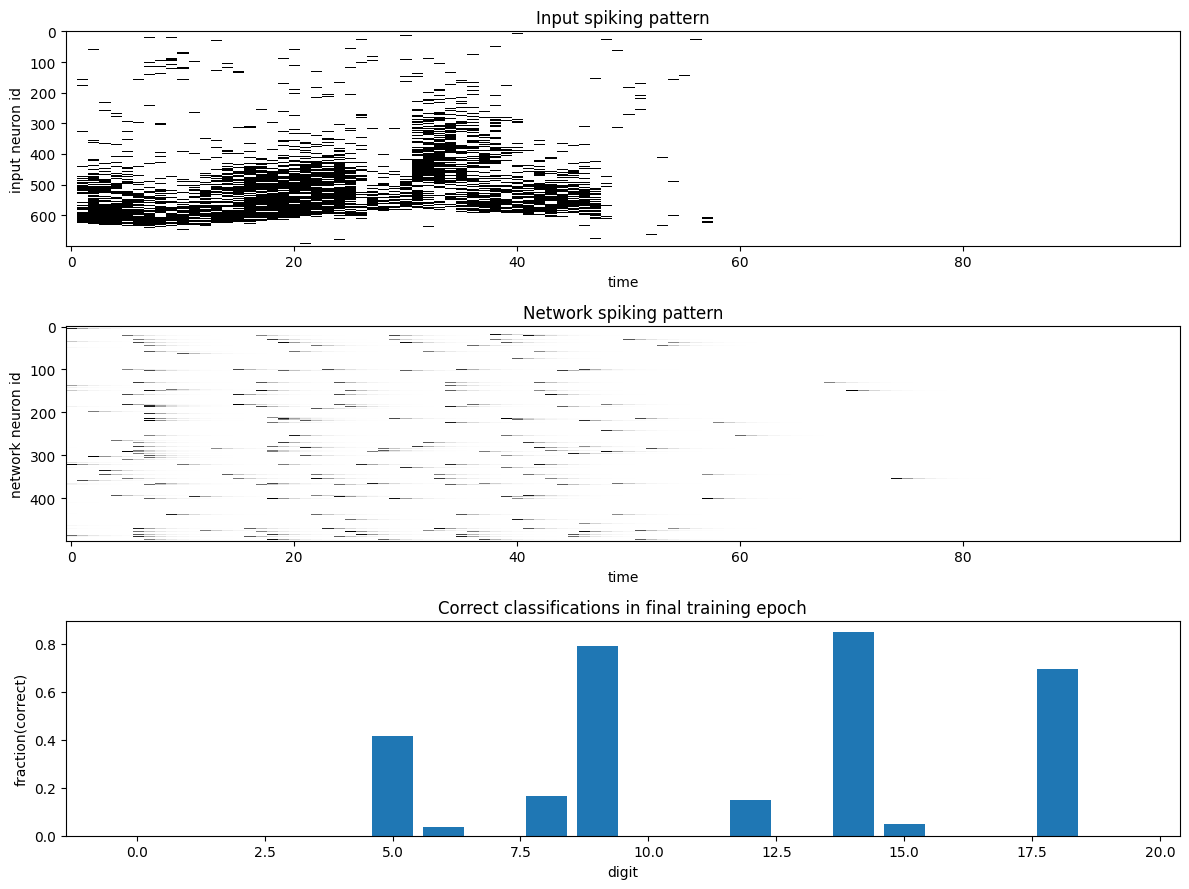

In [49]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))

ax = axes[0]
ax.imshow(X.cpu().detach().numpy().T, aspect="auto", interpolation="none", 
          cmap="Greys")
ax.set_title("Input spiking pattern")
ax.set_xlabel("time")
ax.set_ylabel("input neuron id")
ax = axes[1]
ax.imshow(spikes.cpu().detach().numpy().T, aspect="auto", interpolation="none", 
          cmap="Greys")
ax.set_title("Network spiking pattern")
ax.set_xlabel("time")
ax.set_ylabel("network neuron id")
ax = axes[2]
ax.bar(target_classes, correct_classifications, width=0.8)
ax.set_title("Correct classifications in final training epoch")
ax.set_xlabel("digit")
ax.set_ylabel("fraction(correct)")
plt.tight_layout()